In [1]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

## Import Libraries

In [2]:
# Import required libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [3]:
# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

In [4]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (50000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)


## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [5]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    # savefig(filename) - add filename argument
    plt.show()

def plot_loss(history, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))


In [6]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, activation='relu'):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    activation (str): Activation function to use

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # First convolutional layer
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet():
    """
    Function to build a ResNet model using multiple Resnet style blocks.

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = 64
    # potentially a hyperparameter eg: [2, 3, 2]
    num_blocks_list = [2, 2]  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, (3, 3), strides)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=(8, 8))(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [7]:
# Build ResNet model
resnet_model = build_resnet()
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 64)           0         ['batch_normalization[0][0

2024-04-10 15:52:44.641234: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-10 15:52:44.641268: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-10 15:52:44.641280: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-10 15:52:44.641374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-10 15:52:44.641426: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 conv2d_2 (Conv2D)           (None, 32, 32, 64)           36928     ['activation_1[0][0]']        
                                                                                                  
 batch_normalization_2 (Bat  (None, 32, 32, 64)           256       ['conv2d_2[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 add (Add)                   (None, 32, 32, 64)           0         ['batch_normalization_2[0][0]'
                                                                    , 'activation[0][0]']         
                                                                                                  
 activation_2 (Activation)   (None, 32, 32, 64)           0         ['add[0][0]']                 
                                                                                                  
 conv2d_3 

TO DO:
1. keras callbacks: save checkpoint with best performance on validation data (rishie)
2. Add hyperparameter tuning as arguments (gio)
3. Save graphs under different names (gio)
4. ImageDataGenerator - read about this to add augmentation (rishie)
5. Regularization - Dropouts in random/hyperparameter
6. Loading custom data (rishie)

In [9]:
resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, Y_test))


Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 0.9587 - accuracy: 0.6616

2024-04-10 15:53:42.378937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 41s 53ms/step - loss: 0.9587 - accuracy: 0.6616 - val_loss: 0.8797 - val_accuracy: 0.6949
Epoch 2/10
782/782 [==============================] - 40s 51ms/step - loss: 0.6919 - accuracy: 0.7588 - val_loss: 0.7077 - val_accuracy: 0.7556
Epoch 3/10
782/782 [==============================] - 42s 54ms/step - loss: 0.5543 - accuracy: 0.8093 - val_loss: 1.1086 - val_accuracy: 0.6645
Epoch 4/10
782/782 [==============================] - 41s 53ms/step - loss: 0.4663 - accuracy: 0.8395 - val_loss: 0.7807 - val_accuracy: 0.7358
Epoch 5/10
782/782 [==============================] - 40s 51ms/step - loss: 0.3918 - accuracy: 0.8639 - val_loss: 0.5381 - val_accuracy: 0.8167
Epoch 6/10
782/782 [==============================] - 43s 55ms/step - loss: 0.3260 - accuracy: 0.8867 - val_loss: 0.7649 - val_accuracy: 0.7552
Epoch 7/10
782/782 [==============================] - 40s 51ms/step - loss: 0.2727 - accuracy: 0.9068 - val_loss: 0.5274 - val_accuracy: 0.8195
Epo

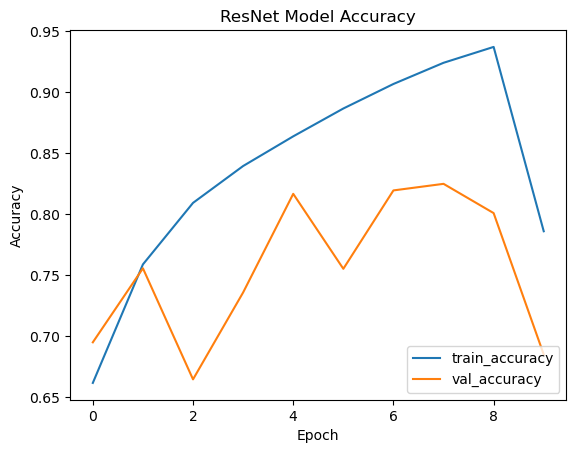

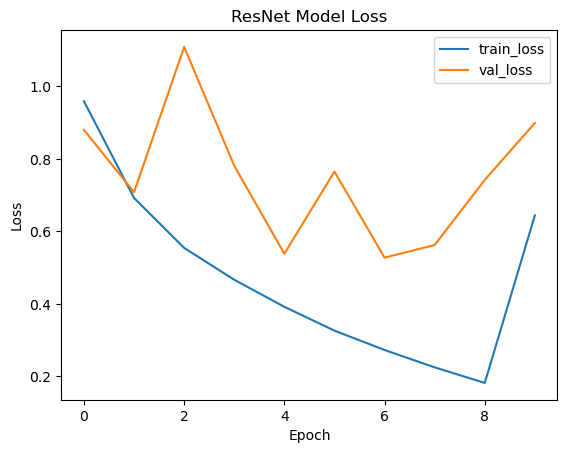

ResNet Model:
Test Accuracy: 68.49%


In [10]:
# Plot accuracy and loss
plot_accuracy(resnet_history, 'ResNet Model Accuracy')
plot_loss(resnet_history, 'ResNet Model Loss')

# Evaluate the model
print('ResNet Model:')
evaluate_model(resnet_model, X_test, Y_test)